In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
forecast_level1 = (pd.read_csv("../output/forecast_level1.csv", parse_dates=["ds"])
                   .rename({"ds":"fcst_date"}, axis=1))
forecast_level1.head()

,fcst_date,y_pred
0,2016-04-25,37819.654281
1,2016-04-26,35308.574794
2,2016-04-27,34276.951094
3,2016-04-28,34244.012754
4,2016-04-29,40125.732164


In [3]:
# LB: 0.56029
date_mapping = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

#filename = "../output/kaggle_submissions/m5-first-public-notebook-under-0-50.csv"
filename = "../output/lgbm_bottom_v40.csv.gz"
forecast_level12 = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )
forecast_level12.head()

,fcst_date,q
0,2016-04-25,37778.911442
1,2016-04-26,35358.463356
2,2016-04-27,34713.182600
3,2016-04-28,34751.197862
4,2016-04-29,40802.765371


***

In [6]:
date_mapping = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

#filename = "../output/kaggle_submissions/m5-first-public-notebook-under-0-50.csv"
filename = "../output/lgbm_bottom_v38.csv.gz"
forecast_level12_base = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )

filename = "../output/lgbm_bottom_v40.csv.gz"
forecast_level12_hts = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )

In [15]:
mrg = (forecast_level1
       .merge(forecast_level12_base, how="inner", on="fcst_date")
       .merge(forecast_level12_hts, how="inner", on="fcst_date")
      )
mrg

,fcst_date,y_pred,q_x,q_y
0,2016-04-25,37819.654281,40922.201497,37778.911442
1,2016-04-26,35308.574794,37777.649251,35358.463356
2,2016-04-27,34276.951094,36750.896734,34713.182600
3,2016-04-28,34244.012754,37076.625277,34751.197862
4,2016-04-29,40125.732164,42485.798053,40802.765371
5,2016-04-30,46214.225551,51351.630119,48808.361243
6,2016-05-01,47453.313465,55220.289343,51410.993680
7,2016-05-02,42584.215194,45990.768810,43561.193520
8,2016-05-03,42203.286395,43858.829824,43286.974148
9,2016-05-04,37912.028116,40038.811375,38533.297096


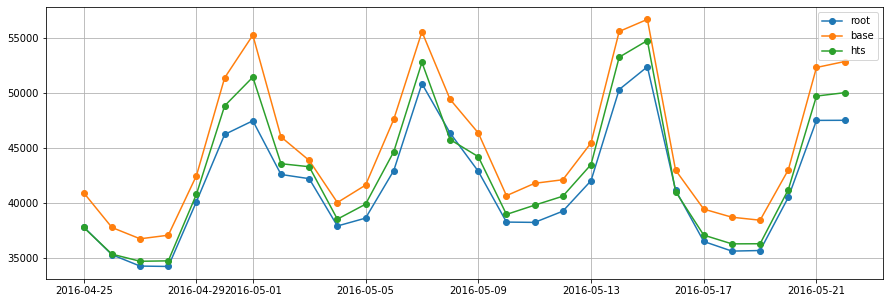

In [16]:
plt.figure(figsize=(15,5))
plt.plot_date(mrg.fcst_date, mrg.y_pred, "o-", label="root")
plt.plot_date(mrg.fcst_date, mrg.q_x, "o-", label="base")
plt.plot_date(mrg.fcst_date, mrg.q_y, "o-", label="hts")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [4]:
kaggle_submissions = dict()

for fname in os.listdir("../output/kaggle_submissions"):
    sub = (pd.read_csv(f"../output/kaggle_submissions/{fname}")
           .loc[0:30489, :]
           .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
           .assign(fcst_date = lambda x: x.F.map(date_mapping))
           .groupby("fcst_date")["q"]
           .sum()
           .reset_index()
           )
    kaggle_submissions[fname] = sub

submission: m5-forecaster-v2.csv


/home/turing/miniconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


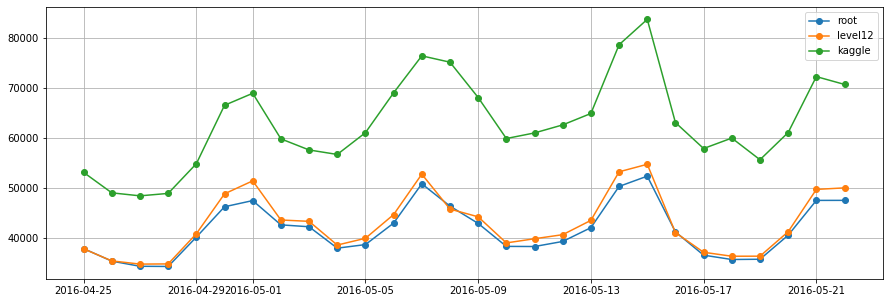

submission: m5-accuracy-tweedie-is-back.csv


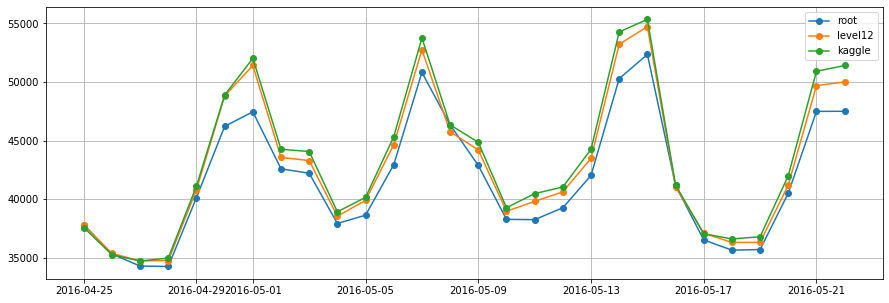

submission: fnu050-num-leaves-76.csv


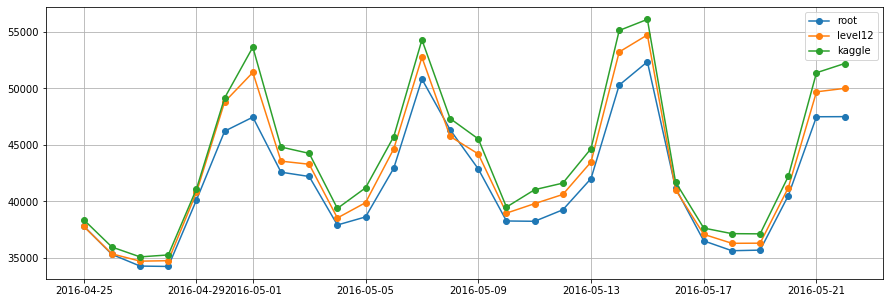

submission: m5-first-public-notebook-under-0-50.csv


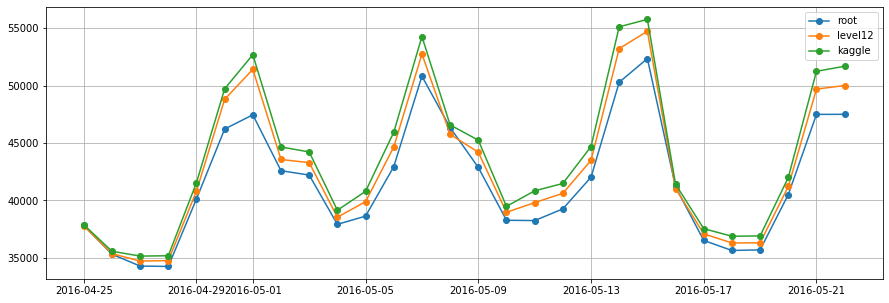

submission: m5-accuracy-poisson-tweedie.csv


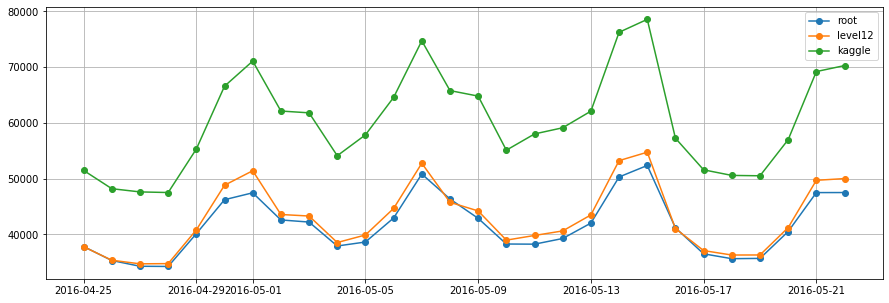

submission: m5-forecast-v2-python.csv


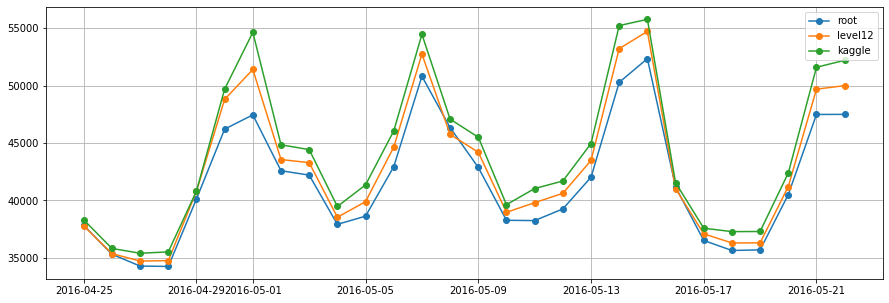

In [5]:
for key,forecast in kaggle_submissions.items():
    mrg = (forecast_level1 
           .merge(forecast_level12, how="inner", on="fcst_date")
           .merge(forecast, how="inner", on="fcst_date"))
    
    print(f"submission: {key}")

    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.fcst_date, mrg.y_pred, "o-", label="root")
    plt.plot_date(mrg.fcst_date, mrg.q_x, "o-", label="level12")
    plt.plot_date(mrg.fcst_date, mrg.q_y, "o-", label="kaggle")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

***